In [1]:
import cv2
from libs.vision import *
from libs.plot import *

# if connection issues, check device manager
# check that camera is allowed in windows privacy settings
# check if antivirus doesn't block the camera

cam = cv2.VideoCapture(1,cv2.CAP_DSHOW)
setup_camera(cam, (1920,1080), 30)
#setup_camera(cam, (1920,1080), 30)

Resolution is: 1920x1080
FPS is: 30


Press 's' to save an image or 'q' to quit.
Image saved to variable 'image'.
Exiting.
Shape: (1080, 1920, 3), pixels 2073600
CPU times: total: 453 ms
Wall time: 62.1 ms


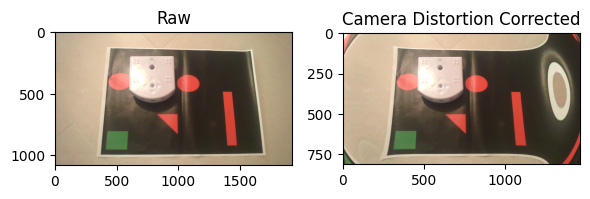

(1080, 1920, 3) (811, 1466, 3)
2073600 1188926


In [2]:
image = get_image_live(cam)

%time image_c = correct_camera_distortion(image, alpha=1)

show_cv2_images(image, image_c,  fig_size=(6,6), color="BGR", titles=("Raw", "Camera Distortion Corrected"))
print(image.shape, image_c.shape)
print(image.shape[0]*image.shape[1], image_c.shape[0]*image_c.shape[1])

In [3]:
show_perspective(image, sigma_init=7, t1_init=100, t2_init=200, epsilon_int=0.1, epsilon_max=0.5)

interactive(children=(IntSlider(value=7, description='Sigma', max=11, min=1, step=2), FloatSlider(value=0.1, d…

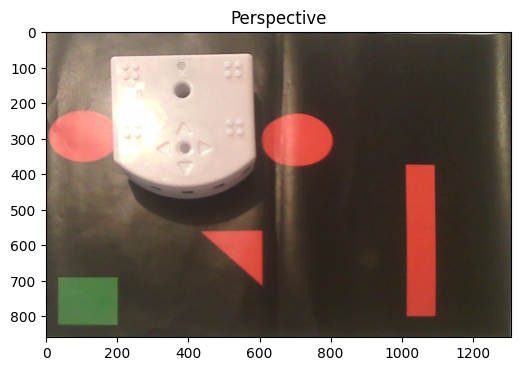

CPU times: total: 422 ms
Wall time: 297 ms


In [4]:
%%time
sigma = 5
t1=50
t2=150
epsilon = 0.1
image = correct_perspective(image, t1=t1, t2=t2, sigma=sigma, epsilon=epsilon)
show_cv2_image(image, fig_size=(6,6), color="BGR", _title="Perspective")

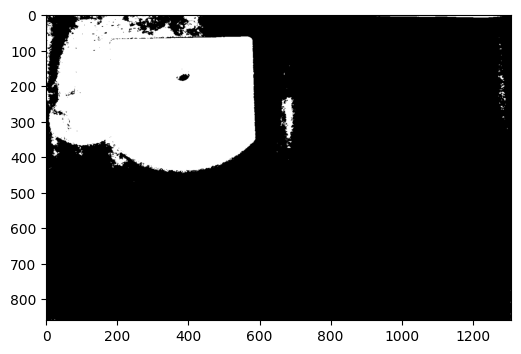

In [5]:
T_WL = 110
thresholded_img = np.zeros_like(image)
thresholded_img = threshold_color(image, thresholded_img, (T_WL, T_WL, T_WL), (255, 255, 255), WHITE)

show_cv2_image(thresholded_img, (6,6), _cmap="gray")

CPU times: total: 15.6 ms
Wall time: 13 ms
CPU times: total: 31.2 ms
Wall time: 35.1 ms
CPU times: total: 15.6 ms
Wall time: 11 ms
CPU times: total: 78.1 ms
Wall time: 6 ms


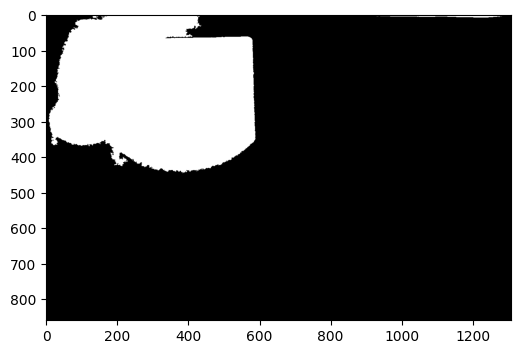

CPU times: total: 281 ms
Wall time: 221 ms


In [6]:
%%time

thresholded_img = np.zeros_like(image)
%time thresholded_img = threshold_color(image, thresholded_img, (T_WL, T_WL, T_WL), (255, 255, 255), WHITE)

%time white_mask = np.all(thresholded_img == WHITE, axis=-1)
%time lcc_white_mask = largest_cc(white_mask)
%time white_filled = fill_holes(lcc_white_mask)
show_cv2_image(white_filled, (6,6), _cmap="gray")

CPU times: total: 0 ns
Wall time: 1.27 ms
CPU times: total: 0 ns
Wall time: 997 μs
CPU times: total: 0 ns
Wall time: 0 ns
CPU times: total: 46.9 ms
Wall time: 39.3 ms


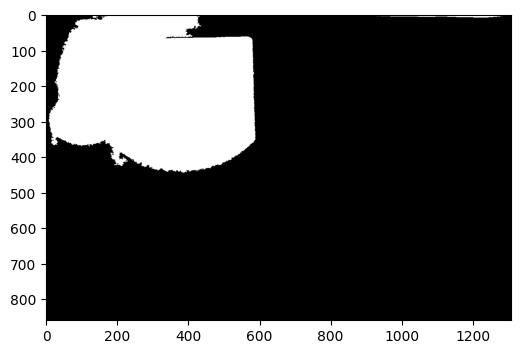

CPU times: total: 203 ms
Wall time: 191 ms


In [7]:
%%time
Thymio_mask = cv2.inRange(image, (T_WL, T_WL, T_WL), (255, 255, 255))
thresholded_img = np.zeros_like(image)

# Find contours
%time contours, _ = cv2.findContours(Thymio_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
%time contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Get the largest contour
cnt = contours[0]

# Create a blank mask and fill the largest contour
filled_mask = np.zeros_like(Thymio_mask)
%time cv2.drawContours(filled_mask, [cnt], -1, 1, thickness=cv2.FILLED)

# Update the thresholded image
thresholded_img[filled_mask > 0] = [255, 255, 255]

# Compute the minimum enclosing circle
%time (_, _), radius = cv2.minEnclosingCircle(cnt)
radius = int(np.ceil(radius))  # Round up to ensure full coverage
kernel_size = 2 * radius + 1  # Kernel size must be odd
kernel = np.zeros((kernel_size, kernel_size), dtype=np.uint8)
cv2.circle(kernel, (radius, radius), radius, 1, thickness=-1)

# Show the result
show_cv2_image(thresholded_img, (6,6))

***

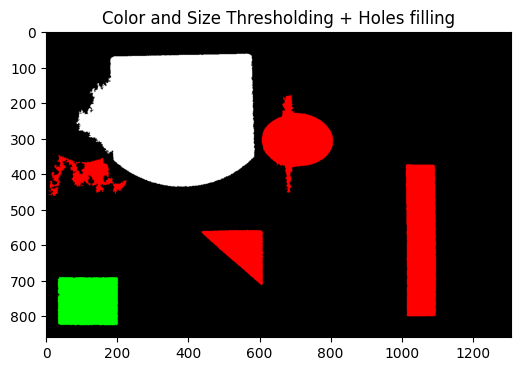

CPU times: total: 1.2 s
Wall time: 1.14 s


In [12]:
%%time
# white lower bound (190,190,190) < (b,g,r) < (255,255,255)
T_WL=138

# (0,0,T_RL) < (b,g,r) < (T_RH,T_RH,255)
T_RH=123 # blue green upper bound for red
T_RL=132 # red lower bound for red

# (0,T_GL,0) < (b,g,r) < (T_GH,255,T_GH)
T_GH=98 # blue red upper bound for green
T_GL=87 # green lower bound for green

min_size=3000

image = threshold_image(image, T_WL, T_RH, T_RL, T_GH, T_GL, min_size)
show_cv2_image(image, fig_size=(6,6), color="BGR", _title="Color and Size Thresholding + Holes filling")

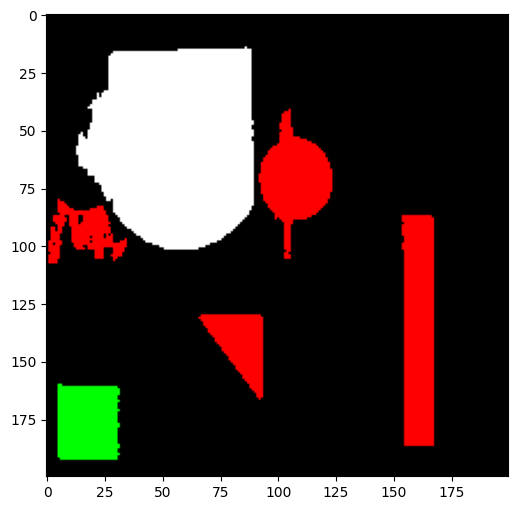

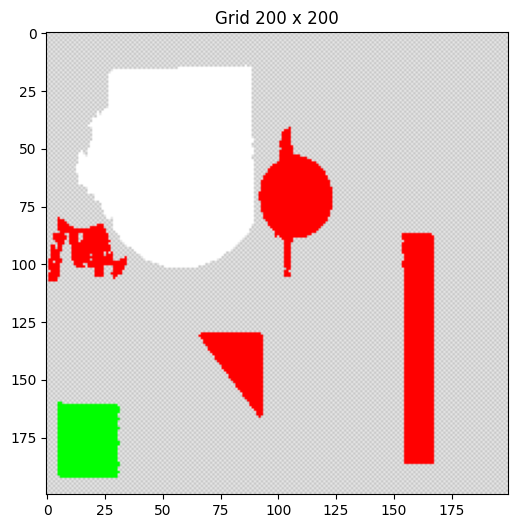

CPU times: total: 1.62 s
Wall time: 1.67 s


In [13]:
%%time
grid_size = 200
grid = get_grid(image, grid_size, verbose=True, full_output=False)

grid_image = grid_to_image(grid)
show_cv2_image(grid_image, (6,6), "BGR")
show_grid(grid)

In [ ]:
mask = (grid == 1).astype(np.uint8)

# Find contours in the binary mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if not contours:
    raise ValueError("No regions with 1 found in the grid.")

# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Get minimum area rectangle around the largest contour
rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)  # Get box corners
box = np.int32(box)        # Convert to integer

# Create the rectangle mask
rectangle_mask = np.zeros_like(grid, dtype=np.uint8)
cv2.drawContours(rectangle_mask, [box], -1, 1, thickness=cv2.FILLED)

# Create a mask for the robot's contour
contour_mask = np.zeros_like(grid, dtype=np.uint8)
cv2.drawContours(contour_mask, [largest_contour], -1, 1, thickness=cv2.FILLED)

# Subtract the contour mask from the rectangle mask
result_mask = rectangle_mask - contour_mask
result_mask[result_mask < 0] = 0

show_cv2_image(result_mask)